<a href="https://colab.research.google.com/github/deen1113/NFLStatsBot/blob/main/DeenKhan_RotobotAITechnical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical Assessment


## Prep and Intro EDA

First, we need to initialize the dataframe:

In [ ]:
import pandas as pd

df = pd.read_csv('weekly_ss_scaled.csv')

Next we need to clean up the data using the provided cleaning criteria - dropping duplicates, coercing numberics, uppercasing team codes, removing the unnamed column, and converting '--' into NaN'.

In [ ]:
df.drop_duplicates(inplace=True)

df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

df.replace('--', pd.NA, inplace=True)

# using errors=ignore, we coerce only the numbers and ignore str terms
# before, I was using errors='coerce' which was giving errors later
df = df.apply(pd.to_numeric, errors='ignore')

df['team_abbreviation'] = df['team_abbreviation'].str.upper()

<ipython-input-2-91aa64732ee7>:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


Next, we will plot the data using matplotlib in order to interpret the data.

<Figure size 640x480 with 0 Axes>

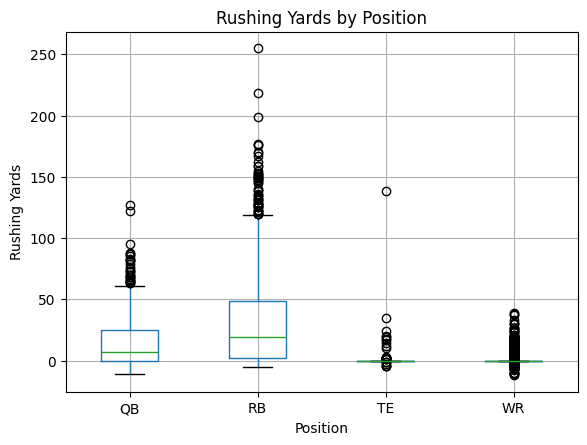

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot(column='rushing_yards', by='position')
plt.title('Rushing Yards by Position')
plt.suptitle('') # removes default title
plt.xlabel('Position')
plt.ylabel('Rushing Yards')
plt.show()

Based on this boxplot, we can safely assume that players in the running back position will have the most rushing yards, followed by quarter backs. Tight ends and wide recievers have many less rushing yards, except for a few outliers. When scoring players, position will be very important because different positions clearly have better statistics in specific catagories.

Now we will generate a heatmap to view the correlation among yards after contact, yards after catch, and rushing yards.

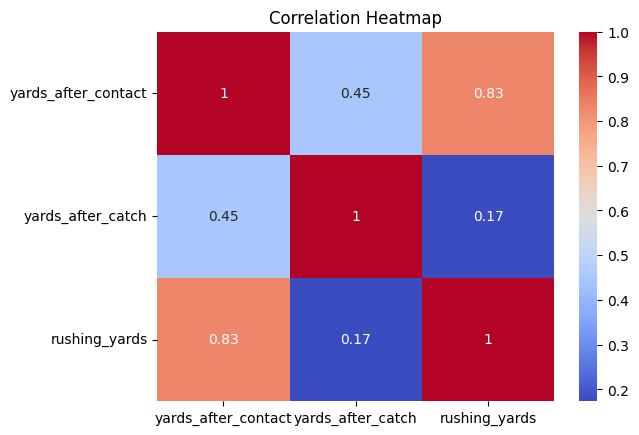

In [ ]:
import seaborn as sns

cols = ['yards_after_contact', 'yards_after_catch', 'rushing_yards']

pivot_data = df[cols].corr() # correlation matrix

plt.figure()
sns.heatmap(pivot_data, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Based on this correlation heat map, we can make a couple claims. First, the strong correlation (0.83) between yards after contact and rushing yards shows that a most of a rusher's yards come after initial contact. The moderate correlation (0.45) between yards after catch and yards after contact shows that both of these stats show open field performance but in different contexts. The weak correlation (0.17) between yards after catch and rushing yards makes sense since yards after catch happens after receptions, not runs.

## Scoring System
Now I will introduce my scoring system.\
There are 4 different positions that need to be scored and each position has different statistics that showcase their abilities.\
For QB I will use completion percent, passing yards, rushing yards, passing touchdowns, interception percent, and 4th quarter passer rating.\
For RB I will use rushing yards, rushing touchdowns, yards after contact, receptions, receiving yards, and yards per rush.\
For WR I will use receiving targets, receiving yards, receiving touchdowns, catch rate and yards after catch.\
For TE I will use receiving yards, receiving touchdowns, redzone receiving touchdowns, catch rate and yards after catch.

In [ ]:
import numpy as np

def score(df: pd.DataFrame) -> pd.Series:
  """
  Returns a score from 0-100 for each player in the dataframe.
  """

  # make a copy of the dataframe so any changes do not mutate the original
  df = df.copy()

  # calculating stats that are not included in the original dataframe
  # replacing 0 with nan avoids dividing by 0 in denominator
  df['completion_pct'] = df['pass_completion'] / df['pass_attempt'].fillna(0)
  df['yards_per_rush'] = df['rushing_yards'] / df['rushing_attempt'].fillna(0)
  df['catch_rate'] = df['reception'] / df['receiving_targets'].fillna(0)
  df['interception_pct'] = df['interceptions'] / df['pass_attempt'].fillna(0)

  # defining 4th quarter passer rating takes a little extra work
  # I am following the NFL passer rating formula = ((a+b+c+d) / 6) * 100

  Q4pass_atmpt = df['pass_attempt_4th_quarter'].fillna(0)
  Q4pass_comp = df['pass_completion_4th_quarter']
  Q4pass_tds = df['passing_touchdowns_4th_quarter']
  Q4pass_yds = df['passing_yards_4th_quarter']
  Q4pass_int = df['interceptions_4th_quarter']

  a = ((Q4pass_comp / Q4pass_atmpt) - 0.3) * 5
  b = ((Q4pass_yds / Q4pass_atmpt) - 3) * 0.25
  c = (Q4pass_tds / Q4pass_atmpt) * 20
  d = 2.375 - ((Q4pass_int / Q4pass_atmpt) * 25)

  # NFL formula rounds down to 2.375 and up to 0
  for num in (a, b, c, d):
    num.clip(lower=0, upper=2.375, inplace=True)

  df['4th_quarter_passer_rating'] = ((a + b + c + d) / 6) * 100

  # mapping features to weights
  feature_map = {
      'QB': ['completion_pct', 'passing_yards', 'rushing_yards', 'passing_touchdowns', 'interception_pct', '4th_quarter_passer_rating'],
      'RB': ['rushing_yards', 'rushing_touchdown', 'yards_after_contact', 'reception', 'receiving_yards', 'yards_per_rush'],
      'WR': ['receiving_targets', 'receiving_yards', 'receiving_touchdown', 'yards_after_catch', 'catch_rate'],
      'TE': ['receiving_yards', 'receiving_touchdown', 'yards_after_catch', 'catch_rate', 'receiving_touchdown_redzone']
  }

  weight_map = {
      'QB': {'completion_pct':0.2, 'passing_yards':0.3, 'rushing_yards':0.1, 'passing_touchdowns':0.2, 'interception_pct':-0.1, '4th_quarter_passer_rating':0.3},
      'RB': {'rushing_yards':0.35, 'rushing_touchdown':0.2, 'yards_after_contact':0.2, 'reception':0.05, 'receiving_yards':0.05, 'yards_per_rush':0.15},
      'WR': {'receiving_targets':0.3, 'receiving_yards':0.2, 'receiving_touchdown':0.2, 'yards_after_catch':0.1, 'catch_rate':0.2},
      'TE': {'receiving_yards':0.35, 'receiving_touchdown':0.1, 'yards_after_catch':0.1, 'catch_rate':0.25, 'receiving_touchdown_redzone':.2}
  }

  # normalizing stats onto a 0-1 scale by ranking players' stats
  # .rank takes a value's rank divided by the total count
  for pos, feats in feature_map.items():
        # gets all players of the same position
        mask = df['position'] == pos
        for feat in feats:
            # makes a new column for the normalized data
            df.loc[mask, feat + '_pct'] = (
                df.loc[mask, feat]
                  .rank(pct=True, na_option='keep')
                  .fillna(0)
            )

  # takes normalized stats and multiplies it by the given weight
  # then adds to total score
  df['raw_score'] = 0.0
  for pos, feats in feature_map.items():
      mask = df['position'] == pos
      w = weight_map[pos]
      # weighted sum of the normalized columns
      df.loc[mask, 'raw_score'] = sum(
          df.loc[mask, feat + '_pct'] * w[feat] for feat in feats
      )


  # scales score from 0-1 to 0-100
  df['weekly_score'] = (
      df.groupby('position')['raw_score']
        .rank(pct=True, na_option='keep')
        .fillna(0)
        * 100
  )

  return df['weekly_score']


In [ ]:
df['weekly_score'] = score(df)

### Explaining the weight distributions



*   Quarterbacks
  *  Should be able to make complete passes and high passing yards per game - .5 for these stats
  * Should be able to secure touchdowns through passes - .2
  * Should be able to make good passes especially when it matters - passer rating 4Q .3
  * Should be making smart plays and good throw selection, avoiding interceptions - interception pct -.1
  * Should be able to run the ball when needed - rushing yards .1

* Running backs
  * Should be able to get high rushing yards and rushing touchdowns - majority of rating .55
  * Should be able to gain yards even under pressure from defenders - yards after contact 0.2
  * Should be able to receive and make receiving touchdowns when needed as a well rounded player - for receiving stats .1
  * Should be able to consistently and efficiently get yards each rush - 0.15

* Wide receivers
  * Should be a high target for catches, as players who are targets often have high fantasy ceilings - .3
  * Should also have a high catch rate, as they should eb able to catch the passes thrown to them - .2
  * Should be able to gain yards off of a pass as well as be able to catch longer passes - YAC and receiving yards .3
  * Should be able to get touchdowns - receiving tds .2

* Tight ends
  * Should be able to catch the passes thrown to them, since they are normally thrown shorter passes - catch rate .25
  * Should still be able to convert yards off of them - receiving yards and YAC .45
  * Should be able to get touchdowns, especially in redzone - receiving tds/redzone receiving touchdowns .3

## Text-To-SQL Chatbot

Now that we have a working scoring function that uses each player's stats depending on their position to generate them a weekly score, we can write a chatbot that can take a query and answer from the database.

In [ ]:
import sqlite3
import os
import boto3
from google.colab import userdata
from langchain_aws import ChatBedrock

os.environ["AWS_ACCESS_KEY_ID"] = userdata.get("AWS_ACCESS_KEY")
os.environ["AWS_SECRET_ACCESS_KEY"] = userdata.get("AWS_SECRET_ACCESS_KEY")

conn = sqlite3.connect('weekly_stats.db')
df.to_sql(
    name='weekly_stats',
    con=conn,
    if_exists='replace',
    index=False
)

cheat_sheet = """
You are talking to an NFL weekly_stats table with columns:
  • pass_attempt (int)
  • pass_completion (int)
  • passing_yards (int)
  • passing_touchdowns (int)
  • rushing_yards (int)
  • receptions (int)
  • receiving_yards (int)
  • weekly_score (float 0–100)
  • position (str: 'QB','RB','WR','TE')
  • player_name (str)
  • team_abbreviation
Rules:
  1. Read-only queries.
  2. Return only the SQL SELECT statement.
  3. Cap at 20 rows by appending "LIMIT 20".
If a column isn’t listed, ask the user to clarify.
"""

prompt_template = """
{cheat_sheet}

The user is asking the following question:
{question}

Return only the SQL SELECT statement with no other text.
If the user does not ask for specific games, use SUM or AVG to aggregate the data.
"""

def ask_chatbot(question: str) -> pd.DataFrame | None:
  model = ChatBedrock(
        credentials_profile_name=None,
        region_name="us-east-1",
        model_id="anthropic.claude-3-5-sonnet-20240620-v1:0",
        model_kwargs={"temperature": 0.2, "max_tokens": 1024}
    )

  prompt = prompt_template.format(
      cheat_sheet=cheat_sheet,
      question=question
      )

  response = model.invoke(prompt)

  sql = response.content

  if "limit" not in sql.lower():
        sql += " LIMIT 20"

  try:

    return pd.read_sql(sql, conn)
  except Exception as e:
    print(response.content)
    return

In [ ]:
print(ask_chatbot("Which QBs had over 3000 passing_yards and 20 passing_touchdowns accross the whole season"))

       player_name team_abbreviation  total_passing_yards  \
0       Joe Burrow               CIN                 4640   
1       Jared Goff               DET                 4397   
2   Baker Mayfield                TB                 4254   
3    Lamar Jackson               BAL                 4023   
4      Sam Darnold               MIN                 3730   
5  Patrick Mahomes                KC                 3638   
6           Bo Nix               DEN                 3445   
7   Jayden Daniels               WAS                 3334   

   total_passing_touchdowns  
0                        29  
1                        28  
2                        23  
3                        27  
4                        23  
5                        21  
6                        28  
7                        21  


In [ ]:
print(ask_chatbot("Show the top 5 in week 1."))

         player_name position team_abbreviation  weekly_score
0  Amon-Ra St. Brown       WR               DET    100.000000
1         Jared Goff       QB               DET    100.000000
2     Saquon Barkley       RB               PHI    100.000000
3        Jonnu Smith       TE               MIA    100.000000
4       Chris Godwin       WR                TB     99.968254


In [ ]:
# print(ask_chatbot("Show the top 5 RBs with names by rushing yards."))

In [ ]:
# print(ask_chatbot("Show the bottom 5 RBs with names by rushing yards."))

In [ ]:
print(ask_chatbot("Select 10 random players with positions and order them by their weekly score"))

In [ ]:
df_test = df.sort_values(by=['weekly_score'], ascending=False)
df_test = df_test[['title', 'position', 'player_name', 'weekly_score']]
df_test.head(50)


,title,position,player_name,weekly_score
4603,MIA @ IND,TE,Jonnu Smith,100.000000
388,JAC @ DET,WR,Amon-Ra St. Brown,100.000000
402,JAC @ DET,QB,Jared Goff,100.000000
3922,PHI @ LA,RB,Saquon Barkley,100.000000
3093,TB @ NO,WR,Chris Godwin,99.968254
5458,GB @ JAC,TE,Tucker Kraft,99.939795
4330,SEA @ ARI,RB,Zach Charbonnet,99.937500
5496,BAL @ CIN,WR,Ja'Marr Chase,99.936508
1698,CIN @ DAL,WR,Ja'Marr Chase,99.904762
4385,JAC @ CHI,TE,Cole Kmet,99.879591
